In [1]:
    # Import necessary libraries
import requests
import pytz
import pandas as pd
from functions.ind_zigzag import calculate_zigzag
from functions.ind_zigzag_interp import zigzag_interp
from functions.ind_ema import calculate_ema
import plotly.graph_objects as go

In [2]:
def fetch_ohlcv_data(symbol, interval, limit):
    base_url = "https://api.binance.us"
    endpoint = "/api/v3/klines"

    # Convert the interval to milliseconds
    # Note: Binance US API expects interval in format like '1m', '1h', '1d'
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit
    }

    try:
        response = requests.get(base_url + endpoint, params=params)
        response.raise_for_status()  # Will raise an HTTPError if the HTTP request returned an unsuccessful status code
        data = response.json()
        return data
    except requests.exceptions.HTTPError as err:
        print(f"HTTP error occurred: {err}")
    except Exception as e:
        print(f"Other error occurred: {e}")

    return None

In [3]:
# Function to preprocess the data into pandas DataFrame
def preprocess_ohlcv_data(data):
    df = pd.DataFrame(data, columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])
    df['Time'] = pd.to_datetime(df['Time'], unit='ms')
    # Convert UTC to EST
    est = pytz.timezone('US/Eastern')
    df['Time'] = df['Time'].dt.tz_localize('UTC').dt.tz_convert(est)
    df.set_index('Time', inplace=True)
    for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[column] = df[column].astype(float)
    return df

In [4]:
def plot_symbol_data(symbol, interval, limit, deviation_percent, pivot_legs, candlestick_transparency=0.6):
    data = fetch_ohlcv_data(symbol, interval, limit)
    data_df = preprocess_ohlcv_data(data)
    data_path, retraces = calculate_zigzag(data_df, deviation_percent, pivot_legs)
    data_path.set_index('Time', inplace=True)
    ema_20 = calculate_ema(data_df)
    data_interp = zigzag_interp(data_path)
    data_interp.set_index('Time', inplace=True)
    
    # Create hover texts
    hover_texts_fp1 = [f"Price: {row['Price']}<br>% Change: {round(row['Percentage Change'], 1)}" for idx, row in data_path.iterrows()]
    hover_texts_fp2 = [f"Price: {row['Price']}<br>% Change: {round(row['Percentage Change'], 1)}" for idx, row in data_interp.iterrows()]
    
    # Create plot
    fig = go.Figure(data=[go.Candlestick(
        x=data_df.index,
        open=data_df['Open'],
        high=data_df['High'],
        low=data_df['Low'],
        close=data_df['Close'],
        name='OHLC',
        opacity=candlestick_transparency)])
    fig.add_trace(go.Scatter(x=data_path.index, y=data_path['Price'], mode='lines', name='FP\'1', line=dict(color='black', width=1.0), text=hover_texts_fp1, hoverinfo='text'))
    fig.add_trace(go.Scatter(x=data_interp.index, y=data_interp['Price'], mode='lines+markers', name='FP\'2', line=dict(color='blue', width=1.5), text=hover_texts_fp2, hoverinfo='text'))
    fig.add_trace(go.Scatter(x=ema_20.index, y=ema_20['EMA_20'], mode='lines', name='EMA-20', line=dict(color='black', width=0.5)))
    
    # Update layout
    fig.update_layout(title=f'{symbol}', xaxis_title='Date', yaxis_title='Price', width=1800, height=800)
    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

In [5]:
# Define overall parameters here -->
interval = '1h'
limit = 300

deviation_percent = 1  # % change for a new trend
pivot_legs = 3         # Number of bars for pivot legs

candlestick_transparency = 0.6
line_thickness = 1.5

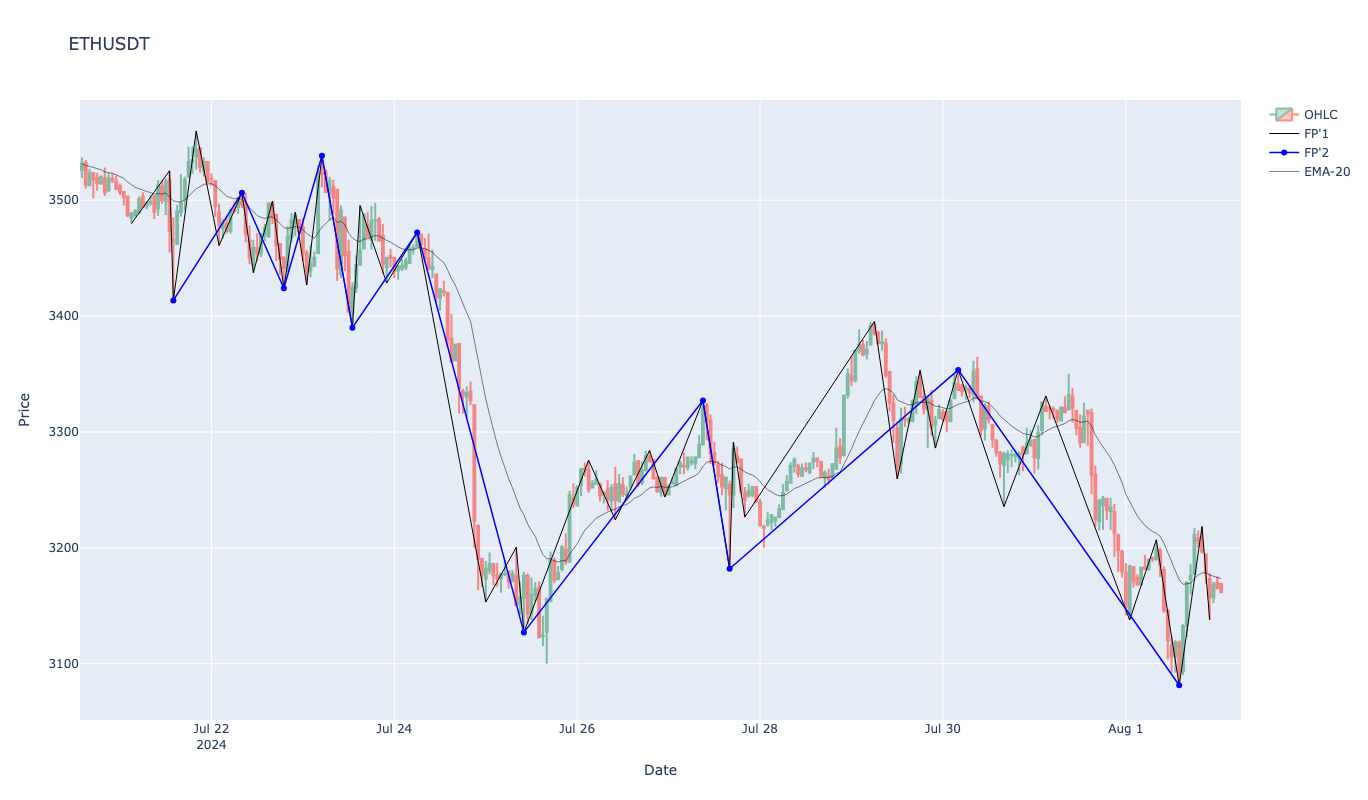

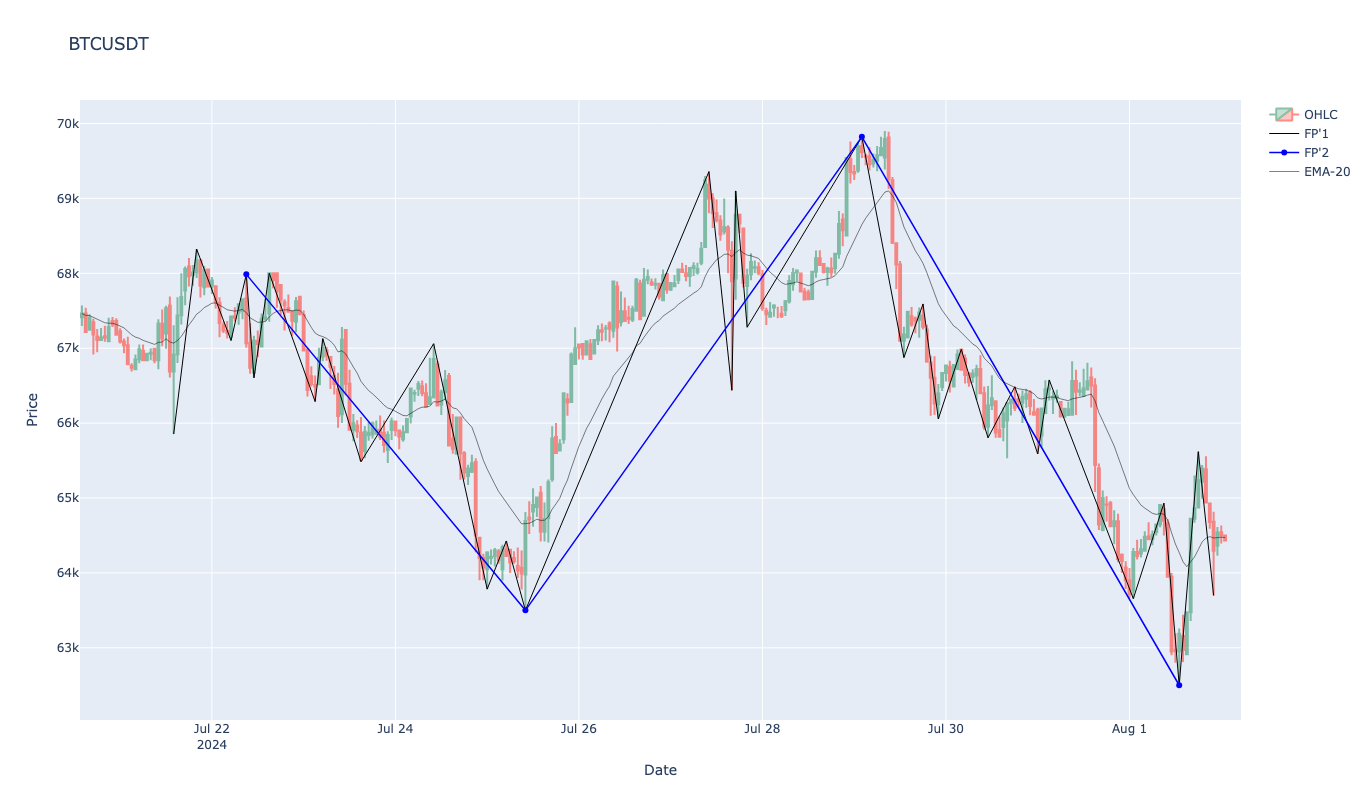

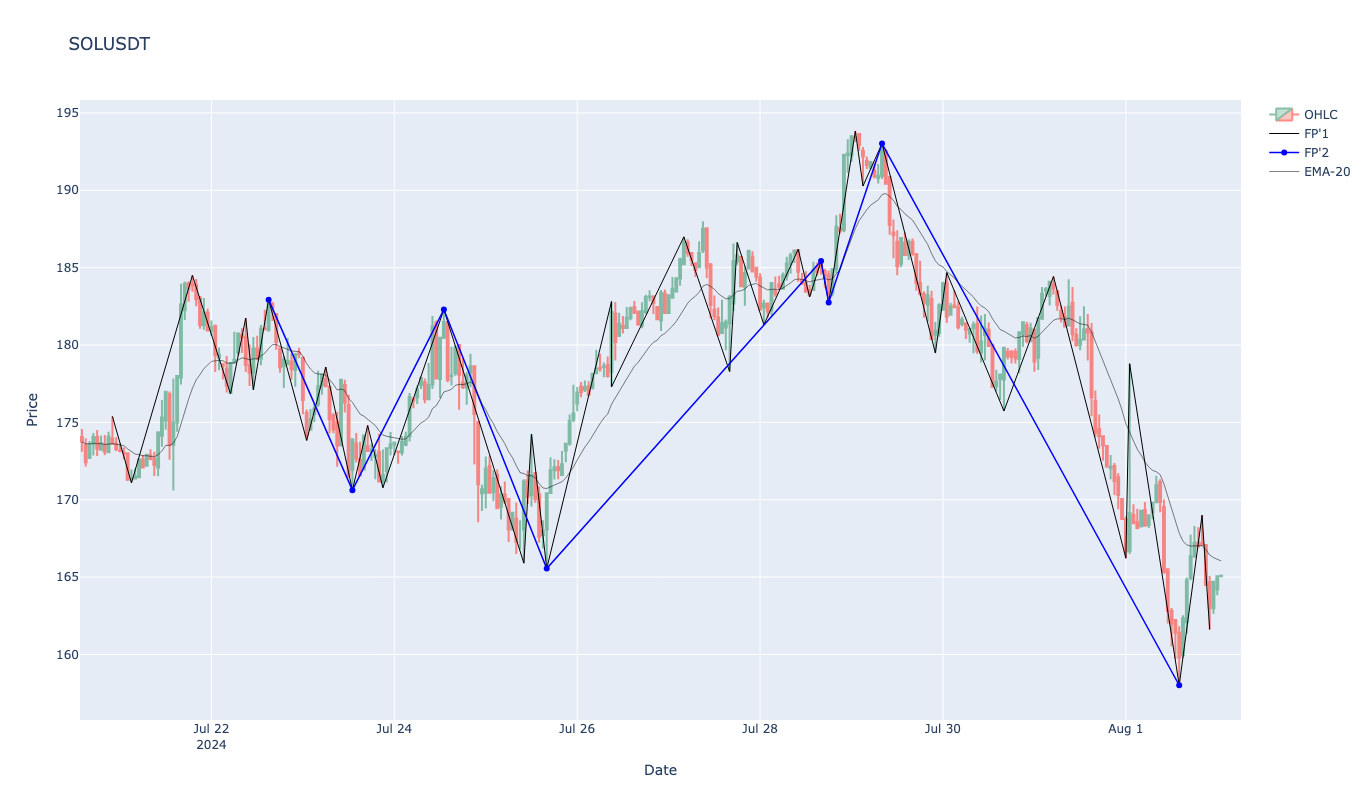

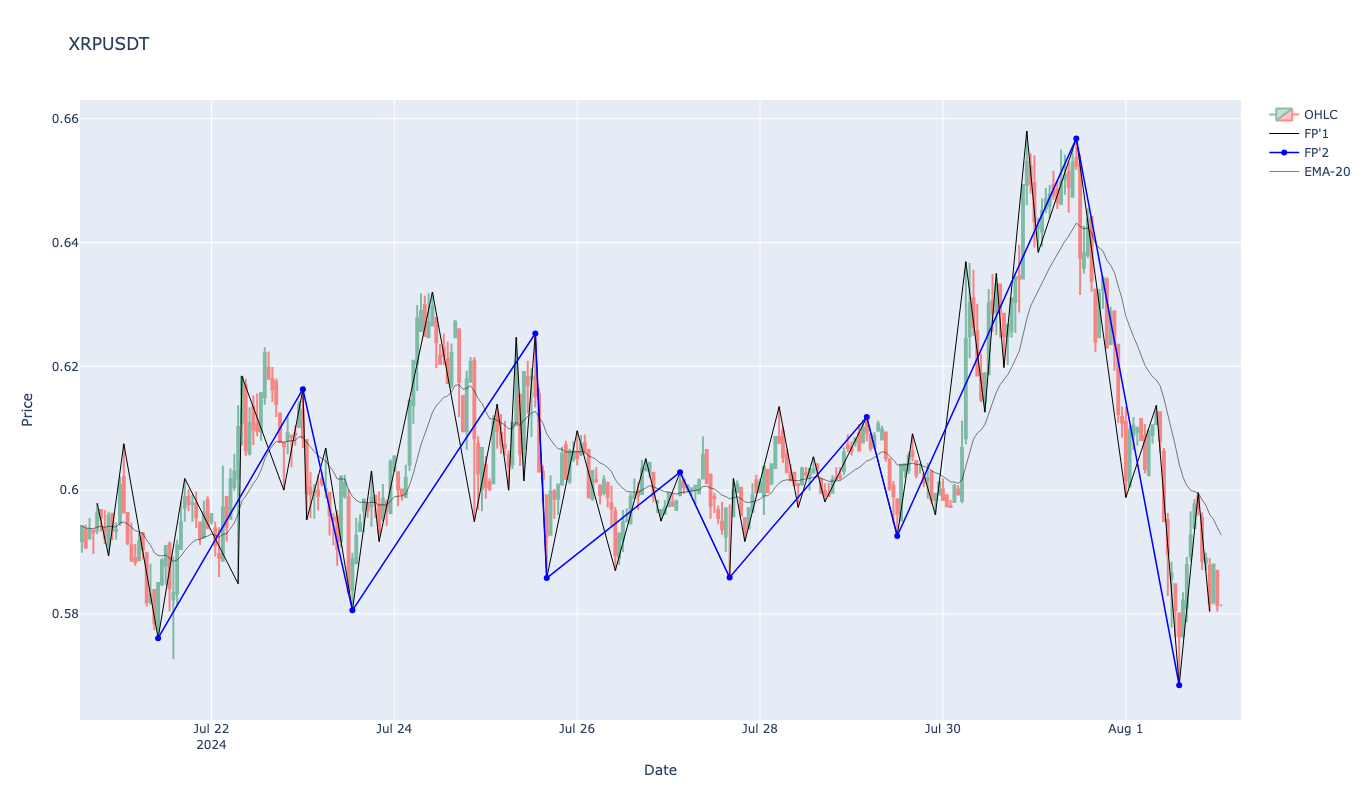

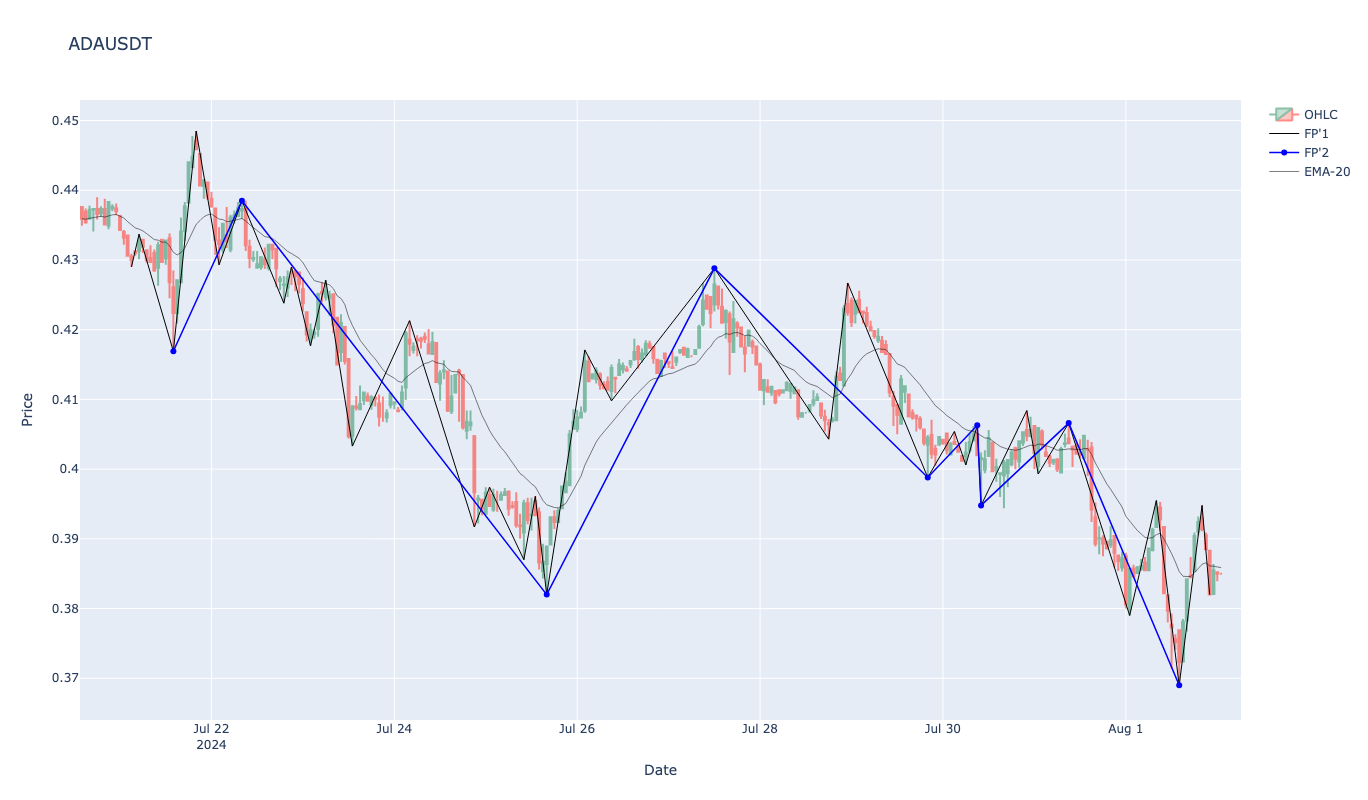

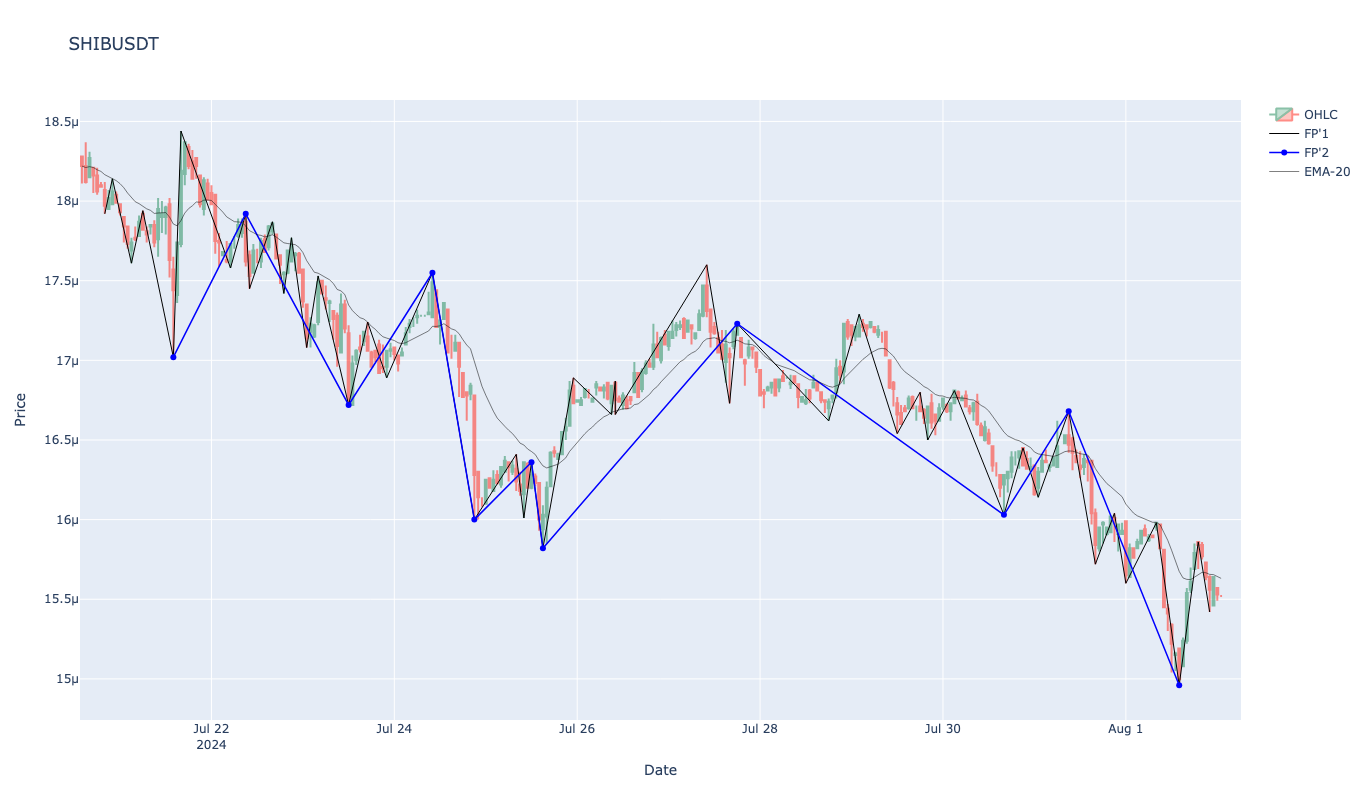

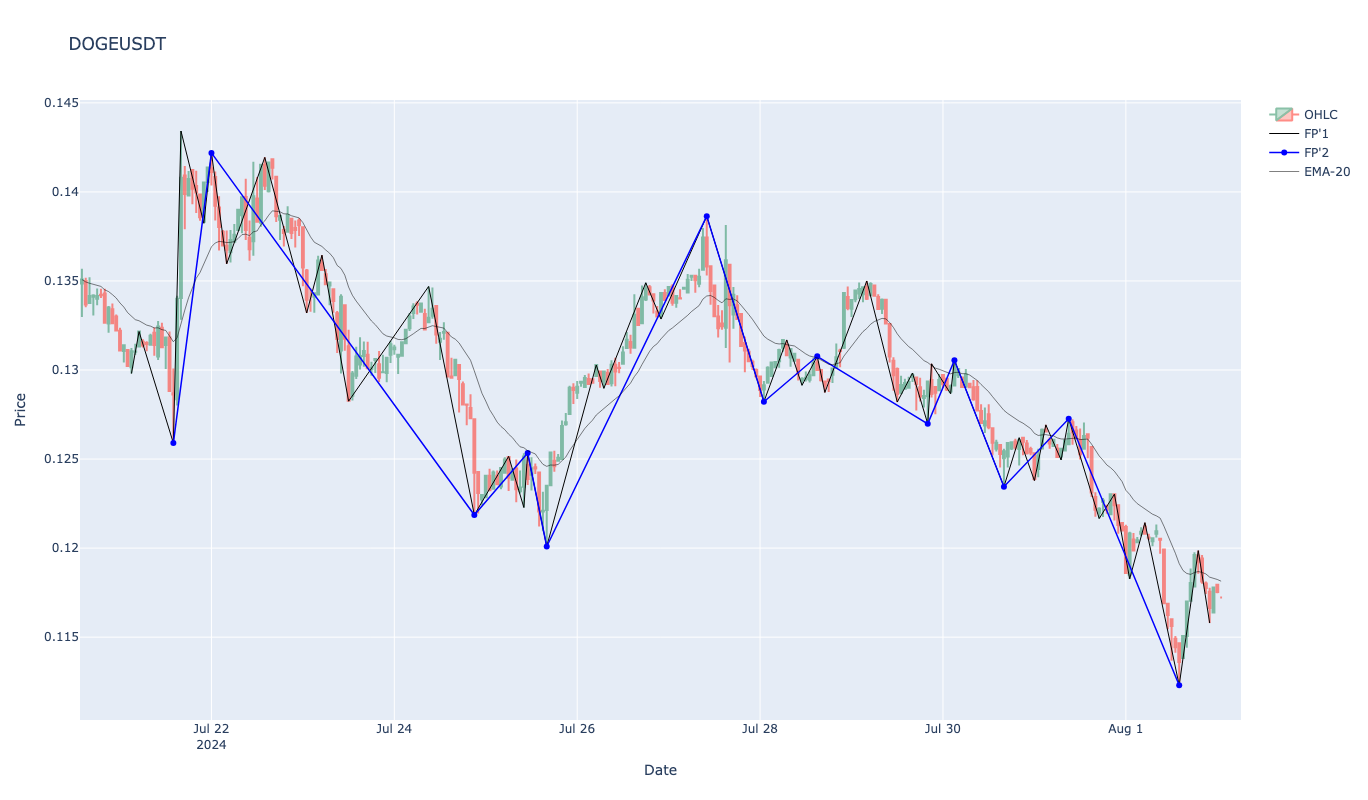

In [6]:
# Run plots
symbols = ['ETHUSDT', 'BTCUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'SHIBUSDT', 'DOGEUSDT']  # Add more symbols as needed
for symbol in symbols:
    plot_symbol_data(symbol, interval, limit, deviation_percent, pivot_legs) 